Using device: cuda
dat shape (neurons × trials): (39209, 5900)

=== Starting 5-fold CV with fold-wise PCA/SAE (no leakage) ===

--- Fold 1/5 ---
  SAE epoch  10/80 | loss=0.288928
  SAE epoch  20/80 | loss=0.084173
  SAE epoch  30/80 | loss=0.051854
  SAE epoch  40/80 | loss=0.039341
  SAE epoch  50/80 | loss=0.032373
  SAE epoch  60/80 | loss=0.027975
  SAE epoch  70/80 | loss=0.024767
  SAE epoch  80/80 | loss=0.022165
  Diagnostics — recon R^2 (tr/te): 0.9928 / 0.7224;  linear Z→X R^2 (tr/te): 0.5802 / 0.5591
    fold 1: finished 100/500 neurons
    fold 1: finished 200/500 neurons
    fold 1: finished 300/500 neurons
    fold 1: finished 400/500 neurons
    fold 1: finished 500/500 neurons

--- Fold 2/5 ---
  SAE epoch  10/80 | loss=0.241538
  SAE epoch  20/80 | loss=0.081649
  SAE epoch  30/80 | loss=0.054275
  SAE epoch  40/80 | loss=0.041936
  SAE epoch  50/80 | loss=0.033562
  SAE epoch  60/80 | loss=0.028512
  SAE epoch  70/80 | loss=0.024868
  SAE epoch  80/80 | loss=0.022125

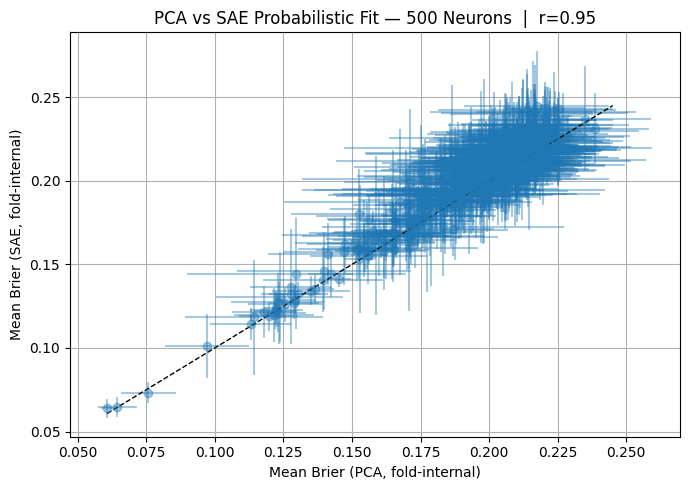


=== SAE Identity Diagnostics (per fold) ===
   fold SAE_on  d_in  d_latent  r2_recon_train  r2_recon_test  \
0     1    pca    15        10          0.9928         0.7224   
1     2    pca    15        10          0.9927         0.6845   
2     3    pca    15        10          0.9905         0.4817   
3     4    pca    15        10          0.9930         0.6409   
4     5    pca    15        10          0.9938         0.6055   

   r2_linear_map_train  r2_linear_map_test  
0               0.5802              0.5591  
1               0.5685              0.4541  
2               0.4992              0.4461  
3               0.5503              0.4819  
4               0.5696              0.5412  

Mean recon R^2 (train/test): 0.9926 / 0.6270
Mean linear Z→X R^2 (train/test): 0.5536 / 0.4965


In [1]:
# ======================================================================
#  5-FOLD CV on 500 Random Neurons — PCA vs SAE (Brier) with No Leakage
#  + Identity Diagnostics (Reconstruction R^2, Linear Z→X R^2)
# ======================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle, warnings, torch, torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.special import softmax
from skbio.stats.composition import clr
from torch.utils.data import DataLoader, TensorDataset
from sklearn.exceptions import ConvergenceWarning

# --------------------------
# Config
# --------------------------
warnings.filterwarnings("ignore", category=ConvergenceWarning)
RNG_SEED = 42
USE_GPU = torch.cuda.is_available()
DEVICE = "cuda" if USE_GPU else "cpu"
np.random.seed(RNG_SEED)
rng = np.random.default_rng(RNG_SEED)
torch.manual_seed(RNG_SEED)

# Representation config
N_COMPONENTS_PCA = 15           # PCA components if using PCA
SAE_LATENT_DIM   = 10           # bottleneck (try 5, 10, 20). < input dims to avoid near-identity
SAE_EPOCHS       = 80
SAE_BATCH        = 256
SAE_LR           = 1e-3
SAE_L1           = 1e-2         # stronger sparsity than before
SAE_ON           = "pca"        # "pca" or "clr"   (what SAE is trained/encoded on)

# CV / sampling
N_FOLDS = 5
N_NEURONS_TO_SAMPLE = 500

print(f"Using device: {DEVICE}")

# --------------------------
# Helpers
# --------------------------
def compute_brier(y_true, y_pred, img_ids):
    """Collapse predictions by image, compute mean Brier score."""
    df = pd.DataFrame({"img": img_ids, "y": y_true, "p": y_pred})
    agg = df.groupby("img", sort=False).mean(numeric_only=True)
    return float(np.mean((agg["p"] - agg["y"]) ** 2))

class SAE(nn.Module):
    def __init__(self, d_in, d_latent):
        super().__init__()
        # Small, simple SAE to discourage near-identity when d_latent < d_in
        self.enc = nn.Sequential(
            nn.Linear(d_in, max(64, d_in)), nn.ReLU(inplace=True),
            nn.Linear(max(64, d_in), d_latent), nn.ReLU(inplace=True)
        )
        self.dec = nn.Sequential(
            nn.Linear(d_latent, max(64, d_in)), nn.ReLU(inplace=True),
            nn.Linear(max(64, d_in), d_in)
        )
    def forward(self, x):
        h = self.enc(x)
        x_hat = self.dec(h)
        return x_hat, h

def train_sae(X_train, d_latent=SAE_LATENT_DIM, epochs=SAE_EPOCHS, batch=SAE_BATCH,
              lr=SAE_LR, l1=SAE_L1, device=DEVICE):
    """Standardize → train SAE; returns (model, scaler)."""
    d_in = X_train.shape[1]
    scaler = StandardScaler().fit(X_train)
    X_std = scaler.transform(X_train).astype(np.float32)

    model = SAE(d_in, d_latent).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    dl = DataLoader(TensorDataset(torch.from_numpy(X_std)), batch_size=batch, shuffle=True)
    model.train()
    for ep in range(1, epochs + 1):
        tot = 0.0
        for (xb,) in dl:
            xb = xb.to(device)
            x_hat, h = model(xb)
            loss = mse(x_hat, xb) + l1 * torch.mean(torch.abs(h))
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item() * xb.size(0)
        if ep % 10 == 0 or ep == epochs:
            print(f"  SAE epoch {ep:3d}/{epochs} | loss={tot/len(dl.dataset):.6f}")
    return model, scaler

@torch.no_grad()
def encode_sae(model, scaler, X, device=DEVICE):
    """Standardize with scaler → encode to Z."""
    model.eval()
    X_std = scaler.transform(X).astype(np.float32)
    xb = torch.from_numpy(X_std).to(device)
    _, h = model(xb)
    return h.cpu().numpy()

@torch.no_grad()
def reconstruct_sae(model, scaler, X, device=DEVICE):
    """Standardize → reconstruct → inverse standardization for R^2 on standardized space."""
    model.eval()
    X_std = scaler.transform(X).astype(np.float32)
    xb = torch.from_numpy(X_std).to(device)
    x_hat, _ = model(xb)
    return x_hat.cpu().numpy(), X_std  # both in standardized space

def linear_map_r2(Z_train, X_train, Z_test, X_test, alpha=1.0):
    """Fit ridge: X ≈ WZ; return train/test R^2."""
    ridge = Ridge(alpha=alpha, fit_intercept=False)
    ridge.fit(Z_train, X_train)
    X_pred_tr = ridge.predict(Z_train)
    X_pred_te = ridge.predict(Z_test)
    return r2_score(X_train, X_pred_tr, multioutput='variance_weighted'), \
           r2_score(X_test,  X_pred_te, multioutput='variance_weighted')

# --------------------------
# Load data
# --------------------------
dat = np.load("/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy")
print("dat shape (neurons × trials):", dat.shape)

path = "/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl"
with open(path, "rb") as f:
    vit_dict = pickle.load(f)["natural_scenes"]

embeddings = np.stack(list(vit_dict))           # (118, 1000)
X = softmax(embeddings, axis=1)                 # (118, 1000)
X_clr = clr(X + 1e-12)                          # (118, 1000)

Y_binary = (dat > 0).astype(int)                # (neurons, 118*50)
n_neurons, n_samples = dat.shape
n_images, n_trials = 118, 50
assert n_samples == n_images * n_trials
img_ids_full = np.repeat(np.arange(n_images), n_trials)

# Replicate image-level features per trial for probes
X_trial_clr = np.repeat(X_clr, n_trials, axis=0)   # (118*50, 1000)

# --------------------------
# Prepare neuron sampling & CV splits
# --------------------------
sampled_neurons = rng.choice(np.arange(n_neurons), size=N_NEURONS_TO_SAMPLE, replace=False)
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
folds = list(kf.split(np.arange(n_images)))

# --------------------------
# Storage
# --------------------------
records = []
diag_rows = []  # identity diagnostics per fold

print("\n=== Starting 5-fold CV with fold-wise PCA/SAE (no leakage) ===")
for fold_id, (train_img_idx, test_img_idx) in enumerate(folds, 1):
    print(f"\n--- Fold {fold_id}/{N_FOLDS} ---")

    # Masks on trial axis
    train_mask = np.isin(img_ids_full, train_img_idx)
    test_mask  = np.isin(img_ids_full, test_img_idx)

    # Choose base matrix for SAE and/or PCA
    if SAE_ON == "pca":
        # Fit PCA on TRAIN images only (image-level), then replicate to trials
        scaler_pca = StandardScaler().fit(X_clr[train_img_idx])
        X_train_img_std = scaler_pca.transform(X_clr[train_img_idx])
        pca = PCA(n_components=N_COMPONENTS_PCA).fit(X_train_img_std)

        # Transform images to PCA, then replicate to trials
        X_img_std = scaler_pca.transform(X_clr)               # all images to std
        X_img_pca = pca.transform(X_img_std)                  # all images to PCA space
        X_trial_pca = np.repeat(X_img_pca, n_trials, axis=0)  # trials

        # Train SAE on TRAIN trials (in PCA space)
        X_train_for_sae = X_trial_pca[train_mask]
        sae_model, sae_scaler = train_sae(X_train_for_sae, d_latent=SAE_LATENT_DIM)

        # Encode to Z on train/test trials
        Z_train = encode_sae(sae_model, sae_scaler, X_trial_pca[train_mask])
        Z_test  = encode_sae(sae_model, sae_scaler, X_trial_pca[test_mask])

        # Identity diagnostics (all in standardized PCA space)
        Xhat_tr_std, Xtr_std = reconstruct_sae(sae_model, sae_scaler, X_trial_pca[train_mask])
        Xhat_te_std, Xte_std = reconstruct_sae(sae_model, sae_scaler, X_trial_pca[test_mask])
        r2_rec_tr = r2_score(Xtr_std, Xhat_tr_std, multioutput='variance_weighted')
        r2_rec_te = r2_score(Xte_std, Xhat_te_std, multioutput='variance_weighted')

        # Linear map Z → X_pca (standardized space): fit on train, eval on test
        # Note: use the SAME standardized space used for SAE (sae_scaler transformed).
        Z_tr_for_lin = Z_train
        Z_te_for_lin = Z_test
        # The targets for mapping are the standardized PCA features the SAE saw:
        r2_lin_tr, r2_lin_te = linear_map_r2(Z_tr_for_lin, Xtr_std, Z_te_for_lin, Xte_std, alpha=1.0)

        # Keep baseline PCA features for probe:
        Xp_train = X_trial_pca[train_mask]
        Xp_test  = X_trial_pca[test_mask]

    elif SAE_ON == "clr":
        # Train SAE directly on CLR (trial-level) using only TRAIN trials
        X_train_for_sae = X_trial_clr[train_mask]
        sae_model, sae_scaler = train_sae(X_train_for_sae, d_latent=SAE_LATENT_DIM)

        Z_train = encode_sae(sae_model, sae_scaler, X_trial_clr[train_mask])
        Z_test  = encode_sae(sae_model, sae_scaler, X_trial_clr[test_mask])

        # Diagnostics in CLR standardized space
        Xhat_tr_std, Xtr_std = reconstruct_sae(sae_model, sae_scaler, X_trial_clr[train_mask])
        Xhat_te_std, Xte_std = reconstruct_sae(sae_model, sae_scaler, X_trial_clr[test_mask])
        r2_rec_tr = r2_score(Xtr_std, Xhat_tr_std, multioutput='variance_weighted')
        r2_rec_te = r2_score(Xte_std, Xhat_te_std, multioutput='variance_weighted')
        r2_lin_tr, r2_lin_te = linear_map_r2(Z_train, Xtr_std, Z_test, Xte_std, alpha=1.0)

        # Also build a PCA baseline (fit on TRAIN images only)
        scaler_pca = StandardScaler().fit(X_clr[train_img_idx])
        X_train_img_std = scaler_pca.transform(X_clr[train_img_idx])
        pca = PCA(n_components=N_COMPONENTS_PCA).fit(X_train_img_std)
        X_img_std = scaler_pca.transform(X_clr)
        X_img_pca = pca.transform(X_img_std)
        X_trial_pca = np.repeat(X_img_pca, n_trials, axis=0)
        Xp_train = X_trial_pca[train_mask]
        Xp_test  = X_trial_pca[test_mask]
    else:
        raise ValueError("SAE_ON must be one of {'pca','clr'}")

    # Log diagnostics for this fold
    diag_rows.append({
        "fold": fold_id,
        "SAE_on": SAE_ON,
        "d_in": Xp_train.shape[1] if SAE_ON=="pca" else X_trial_clr.shape[1],
        "d_latent": SAE_LATENT_DIM,
        "r2_recon_train": r2_rec_tr,
        "r2_recon_test":  r2_rec_te,
        "r2_linear_map_train": r2_lin_tr,
        "r2_linear_map_test":  r2_lin_te
    })
    print(f"  Diagnostics — recon R^2 (tr/te): {r2_rec_tr:.4f} / {r2_rec_te:.4f};  "
          f"linear Z→X R^2 (tr/te): {r2_lin_tr:.4f} / {r2_lin_te:.4f}")

    # Evaluate per neuron (train probe on TRAIN trials, test on TEST trials)
    test_img_ids = img_ids_full[test_mask]

    for i, nid in enumerate(sampled_neurons, 1):
        y_train = Y_binary[nid][train_mask]
        y_test  = Y_binary[nid][test_mask]

        # PCA probe
        log_pca = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
        log_pca.fit(Xp_train, y_train)
        y_pred_pca = log_pca.predict_proba(Xp_test)[:, 1]
        b_pca = compute_brier(y_test, y_pred_pca, test_img_ids)

        # SAE probe
        log_sae = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
        log_sae.fit(Z_train, y_train)
        y_pred_sae = log_sae.predict_proba(Z_test)[:, 1]
        b_sae = compute_brier(y_test, y_pred_sae, test_img_ids)

        records.append({
            "fold": fold_id,
            "neuron_idx": int(nid),
            "Brier_PCA": b_pca,
            "Brier_SAE": b_sae,
            "delta_Brier": b_sae - b_pca
        })

        if i % 100 == 0:
            print(f"    fold {fold_id}: finished {i}/{N_NEURONS_TO_SAMPLE} neurons")

# --------------------------
# Aggregate & report
# --------------------------
df = pd.DataFrame(records)
df_cv = (df.groupby("neuron_idx", as_index=False)
           .agg(Brier_PCA_mean=("Brier_PCA","mean"),
                Brier_PCA_std =("Brier_PCA","std"),
                Brier_SAE_mean=("Brier_SAE","mean"),
                Brier_SAE_std =("Brier_SAE","std"),
                delta_Brier_mean=("delta_Brier","mean")))

print("\n=== 5-Fold Crossvalidated Brier Scores (Held-out Images) ===")
print(df_cv.describe().round(4))

# Correlation of mean Brier across neurons
corr = np.corrcoef(df_cv["Brier_PCA_mean"], df_cv["Brier_SAE_mean"])[0,1]
print(f"\nCorrelation( Brier_PCA_mean , Brier_SAE_mean ) = {corr:.3f}")

# Save results
df_cv.to_csv("brier_results_500neurons_noleak.csv", index=False)
pd.DataFrame(diag_rows).to_csv("sae_identity_diagnostics.csv", index=False)
print("\nSaved → brier_results_500neurons_noleak.csv")
print("Saved → sae_identity_diagnostics.csv")

# --------------------------
# Quick visualization
# --------------------------
plt.figure(figsize=(7,5))
plt.errorbar(df_cv["Brier_PCA_mean"], df_cv["Brier_SAE_mean"],
             xerr=df_cv["Brier_PCA_std"], yerr=df_cv["Brier_SAE_std"],
             fmt='o', alpha=0.4)
lims = [min(df_cv["Brier_PCA_mean"].min(), df_cv["Brier_SAE_mean"].min()),
        max(df_cv["Brier_PCA_mean"].max(), df_cv["Brier_SAE_mean"].max())]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.xlabel("Mean Brier (PCA, fold-internal)")
plt.ylabel("Mean Brier (SAE, fold-internal)")
plt.title(f"PCA vs SAE Probabilistic Fit — {N_NEURONS_TO_SAMPLE} Neurons  |  r={corr:.2f}")
plt.grid(True)
plt.tight_layout()
plt.show()

# Also print diagnostics summary
diag_df = pd.DataFrame(diag_rows)
print("\n=== SAE Identity Diagnostics (per fold) ===")
print(diag_df.round(4))
print("\nMean recon R^2 (train/test): "
      f"{diag_df['r2_recon_train'].mean():.4f} / {diag_df['r2_recon_test'].mean():.4f}")
print("Mean linear Z→X R^2 (train/test): "
      f"{diag_df['r2_linear_map_train'].mean():.4f} / {diag_df['r2_linear_map_test'].mean():.4f}")
